# citysong

an agent-based approach to modeling urban birdsong

#### import statements

In [1]:
import numpy
from matplotlib import pyplot

In [2]:
from math import sqrt, ceil

In [3]:
from numba import jit, guvectorize, int64, float64

In [4]:
import rasterio

#### import suitability

In [5]:
import rasterio
with rasterio.open('SUITABILITY.tif', 'r') as r:
    arr = r.read()[0]  # read all raster values

In [6]:
suitability = numpy.copy(numpy.array(arr[slice(800, 1300, 1), slice(800, 1300, 1)], dtype=numpy.float64))
#suitability = numpy.copy(numpy.array(arr, dtype=numpy.float64))

#### variable declarations

In [7]:
width = suitability.shape[1]
height = suitability.shape[0]

In [8]:
width, height

(500, 500)

In [9]:
seconds = 3600

In [10]:
n_birds = 1

In [11]:
walk = numpy.zeros((width, height), dtype=numpy.int64)

#### create maps

## bird

0 -> row (y position) <br />
1 -> column (x position) <br />
2 -> moving (0 or 1) <br />
3 -> move complete (0-1) <br />
4 -> row (y start) <br />
5 -> column (x start) <br />
6 -> row (y destination) <br />
7 -> column (x destination) <br />
8 -> move distance

#### create birds

In [12]:
birds = numpy.zeros((n_birds, 9), dtype=numpy.int64)
for idx, b in enumerate(birds):
    birds[idx][0] = numpy.random.randint(50, height-50)
    birds[idx][1] = numpy.random.randint(50, width-50)
    birds[idx][2] = 0
    birds[idx][3] = 0
    birds[idx][4] = 0
    birds[idx][5] = 0
    birds[idx][6] = 0
    birds[idx][7] = 0
    birds[idx][8] = 0

## plot habitat

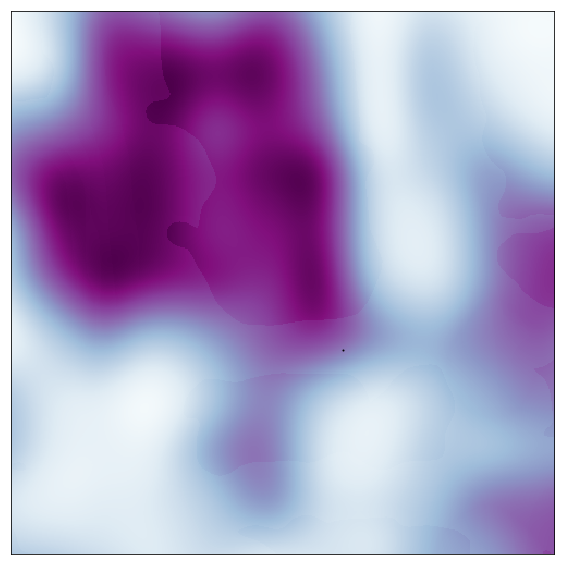

In [13]:
figure, ax = pyplot.subplots()
figure.set_figheight(10)
figure.set_figwidth(10)

ax.imshow(suitability, cmap="BuPu")
ax.scatter(birds[:, 1], birds[:, 0], color='black', s = 1)
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.tick_params(axis='both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')
#figure.savefig("walk_a.png", dpi=150)

## run simulation

In [14]:
def run_guvectorize(suitability, seconds, n_birds, birds, width, height, walk):
    for s in range(seconds):
        for idx in range(n_birds):
            b = birds[idx]
            walk[b[0], b[1]] = idx + 1
            # check if bird is moving
            if b[2]:
                b[3] = b[3] + 1
                p = float(b[3]) / float(b[8])
                # calculate coords and update bird's position
                b[0] = int(ceil((b[6] - b[4]) * p) + b[4])# + numpy.random.randint(-5, 6)
                b[1] = int(ceil((b[7] - b[5]) * p) + b[5])# + numpy.random.randint(-5, 6)
                # check if bird reached destination
                if b[3] == b[8]:
                    b[0] = b[6]
                    b[1] = b[7]
                    b[2] = 0
                    b[3] = 0
                    b[4] = 0
                    b[5] = 0
                    b[6] = 0
                    b[7] = 0
                    b[8] = 0
            # bird is not moving
            else:
                # possibly set bird in motion
                move = numpy.random.randint(0, 100)
                if move < 50:
                # count number of nearby birds:
                    count = ((birds[:, 0] > (b[0] - 25))*(birds[:, 0] < (b[0] + 25))*(birds[:, 1] > (b[1] - 25))*(birds[:, 1]< (b[1] + 25))).sum()
                    if count < 1000:
                        # set bird is moving
                        b[2] = 1
                        # save start destination
                        b[4] = b[0]
                        b[5] = b[1]
                        # determine new destination
                        
                        if move < 2:
                            b[6] = numpy.random.randint(50, height-50)
                            b[7] = numpy.random.randint(50, width-50)
                            
                        else:
                            #calculate distance
                            #dist = int(ceil((1-abs(3-abs(numpy.random.randn()))/3) * 50))
                            dist = int(ceil(numpy.random.rand() * 50))
                            if dist < 1:
                                dist == 1
                            d_top = height - b[0]
                            d_bottom = b[0]
                            d_left = b[1]
                            d_right = width - b[1]

                            r_shift = 0
                            c_shift = 0
                            # shift down
                            if d_top < 50:
                                r_shift = d_top - 50
                            # shift up
                            if d_bottom < 50:
                                r_shift = 50 - d_bottom
                            # shift right
                            if d_left < 50:
                                c_shift = 50 - d_left
                            #shift left
                            if d_right < 50:
                                c_shift = d_right - 50

                            r_slice = slice(b[0]-dist+r_shift,b[0]+dist+r_shift+1,1)
                            c_slice = slice(b[1]-dist+c_shift,b[1]+dist+c_shift+1,1)

                            destinations = suitability[r_slice, c_slice]
                            draw = (abs(3-abs(numpy.random.randn()))/3)
                            #draw = numpy.random.rand()
                            destinations = destinations + destinations.min()
                            threshold = ((destinations.max() - destinations.min()) * draw) + destinations.min()
                            values = numpy.absolute(destinations - threshold)
                            destination = numpy.where(values == values.min())

                            # save new destination
                            dest_c = (destination[1][0] - dist + c_shift) + b[1]
                            dest_r = (destination[0][0] - dist + r_shift) + b[0]

                            b[6] = dest_r
                            b[7] = dest_c
                        
                        # set distance of move
                        b[8] = ceil(sqrt((b[6]-b[4])**2 + (b[7]-b[5])**2))
                        if b[8] < 1:
                            b[8] = 1

In [15]:
run_numba = guvectorize('float64[:,:], int64, int64, int64[:,:], int64, int64, int64[:,:]', '(w,h),(),(),(b,a),(),()->(w,h)', target='parallel', nopython=True)(run_guvectorize)

In [16]:
walk = run_numba(suitability, seconds, n_birds, birds, width, height, walk)

#### plot walk

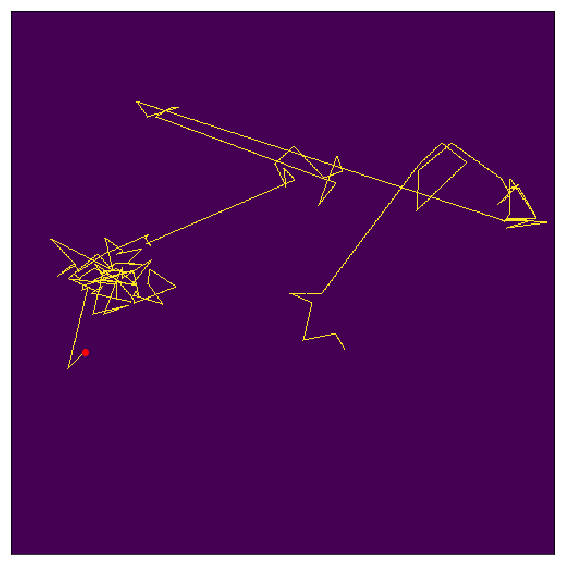

In [18]:
figure, ax = pyplot.subplots()
figure.set_figheight(10)
figure.set_figwidth(10)

#ax.imshow(suitability, cmap='BuPu')
#ax.imshow(cmp_2[slice(50, height+50, 1), slice(50, width+50, 1)], cmap="viridis")
ax.imshow(walk, cmap="viridis")
ax.scatter(birds[:, 1], birds[:, 0], color='red')
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.tick_params(axis='both', which='both', bottom='off', labelbottom='off', left='off', labelleft='off')
#figure.savefig("walk_b3.png", dpi=300)